<a href="https://www.kaggle.com/code/rubanzasilva/eda-gradient-boosting-neural-nets-s04e11?scriptVersionId=205810912" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Exploring mental health - Introduction - Binary Classification.

Here our goal is to use data from a mental health survey to explore factors that may cause individuals to experience depression and use this to classify whether an individual is at risk of depression or not.

The data for this particular competition is synthentically generated from the Depression Survey/Dataset for Analysis linked in the data section of the competition.
The original dataset was collected from a survey carried out among adults aimed and understanding depression risk factors based on inputs provided by particpants in the survey.

Among the dataset notes is

> A number of data artifacts have been left in the synthetic dataset.

which means there are possibly some notable differences between the original dataset and our synthentically generated dataset hence we shall explore both datasets and their differences below.

The target variable is either "0" or "1" hence our goal here will be to predict the target class.

Exploring this dataset can help us understand and provide key insights into how everyday factors contribute to our mental health.

V1
In this notebook, i shall be trying out the following

* Exploring the data
* Neural Networks
* Gradient Boosting
* AutoML
* Ensembles

## Data & Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv
/kaggle/input/playground-series-s4e11/sample_submission.csv
/kaggle/input/playground-series-s4e11/train.csv
/kaggle/input/playground-series-s4e11/test.csv


In [2]:
%%time
%pip install catboost
%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install polars
%pip install -q -U autogluon.tabular
%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [3007 lines of output]
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match you

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,train_test_split,GridSearchCV


from pathlib import Path
import os

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv


import warnings


#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc

import optuna
from optuna.samplers import TPESampler

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

#import h2o
#from h2o.automl import H2OAutoML

In [4]:
path = Path('/kaggle/input/playground-series-s4e11/')
path

Path('/kaggle/input/playground-series-s4e11')

In [5]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
original_df = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [6]:
train_df.shape,original_df.shape

((140700, 19), (2556, 19))

In [7]:
#train_df = pd.concat([train_df, original], ignore_index=True)

# Exploratory Data Analysis

In [8]:
train_df.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [9]:
train_df.shape

(140700, 19)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140700 entries, 0 to 140699
Data columns (total 19 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   140700 non-null  object 
 1   Gender                                 140700 non-null  object 
 2   Age                                    140700 non-null  float64
 3   City                                   140700 non-null  object 
 4   Working Professional or Student        140700 non-null  object 
 5   Profession                             104070 non-null  object 
 6   Academic Pressure                      27897 non-null   float64
 7   Work Pressure                          112782 non-null  float64
 8   CGPA                                   27898 non-null   float64
 9   Study Satisfaction                     27897 non-null   float64
 10  Job Satisfaction                       112790 non-null  float

In [11]:
train_df.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

# Missing Value Check

In [12]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

Study Satisfaction                       112803
Academic Pressure                        112803
CGPA                                     112802
Profession                                36630
Work Pressure                             27918
Job Satisfaction                          27910
Dietary Habits                                4
Financial Stress                              4
Degree                                        2
Family History of Mental Illness              0
Work/Study Hours                              0
Have you ever had suicidal thoughts ?         0
Name                                          0
Sleep Duration                                0
Gender                                        0
Working Professional or Student               0
City                                          0
Age                                           0
Depression                                    0
dtype: int64


In [13]:
#Missing values returned as percentages.
missing_percentages = train_df.isnull().mean() * 100
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
print(sorted_missing_percentages)

Study Satisfaction                       80.172708
Academic Pressure                        80.172708
CGPA                                     80.171997
Profession                               26.034115
Work Pressure                            19.842217
Job Satisfaction                         19.836532
Dietary Habits                            0.002843
Financial Stress                          0.002843
Degree                                    0.001421
Family History of Mental Illness          0.000000
Work/Study Hours                          0.000000
Have you ever had suicidal thoughts ?     0.000000
Name                                      0.000000
Sleep Duration                            0.000000
Gender                                    0.000000
Working Professional or Student           0.000000
City                                      0.000000
Age                                       0.000000
Depression                                0.000000
dtype: float64


## Summary Statistics

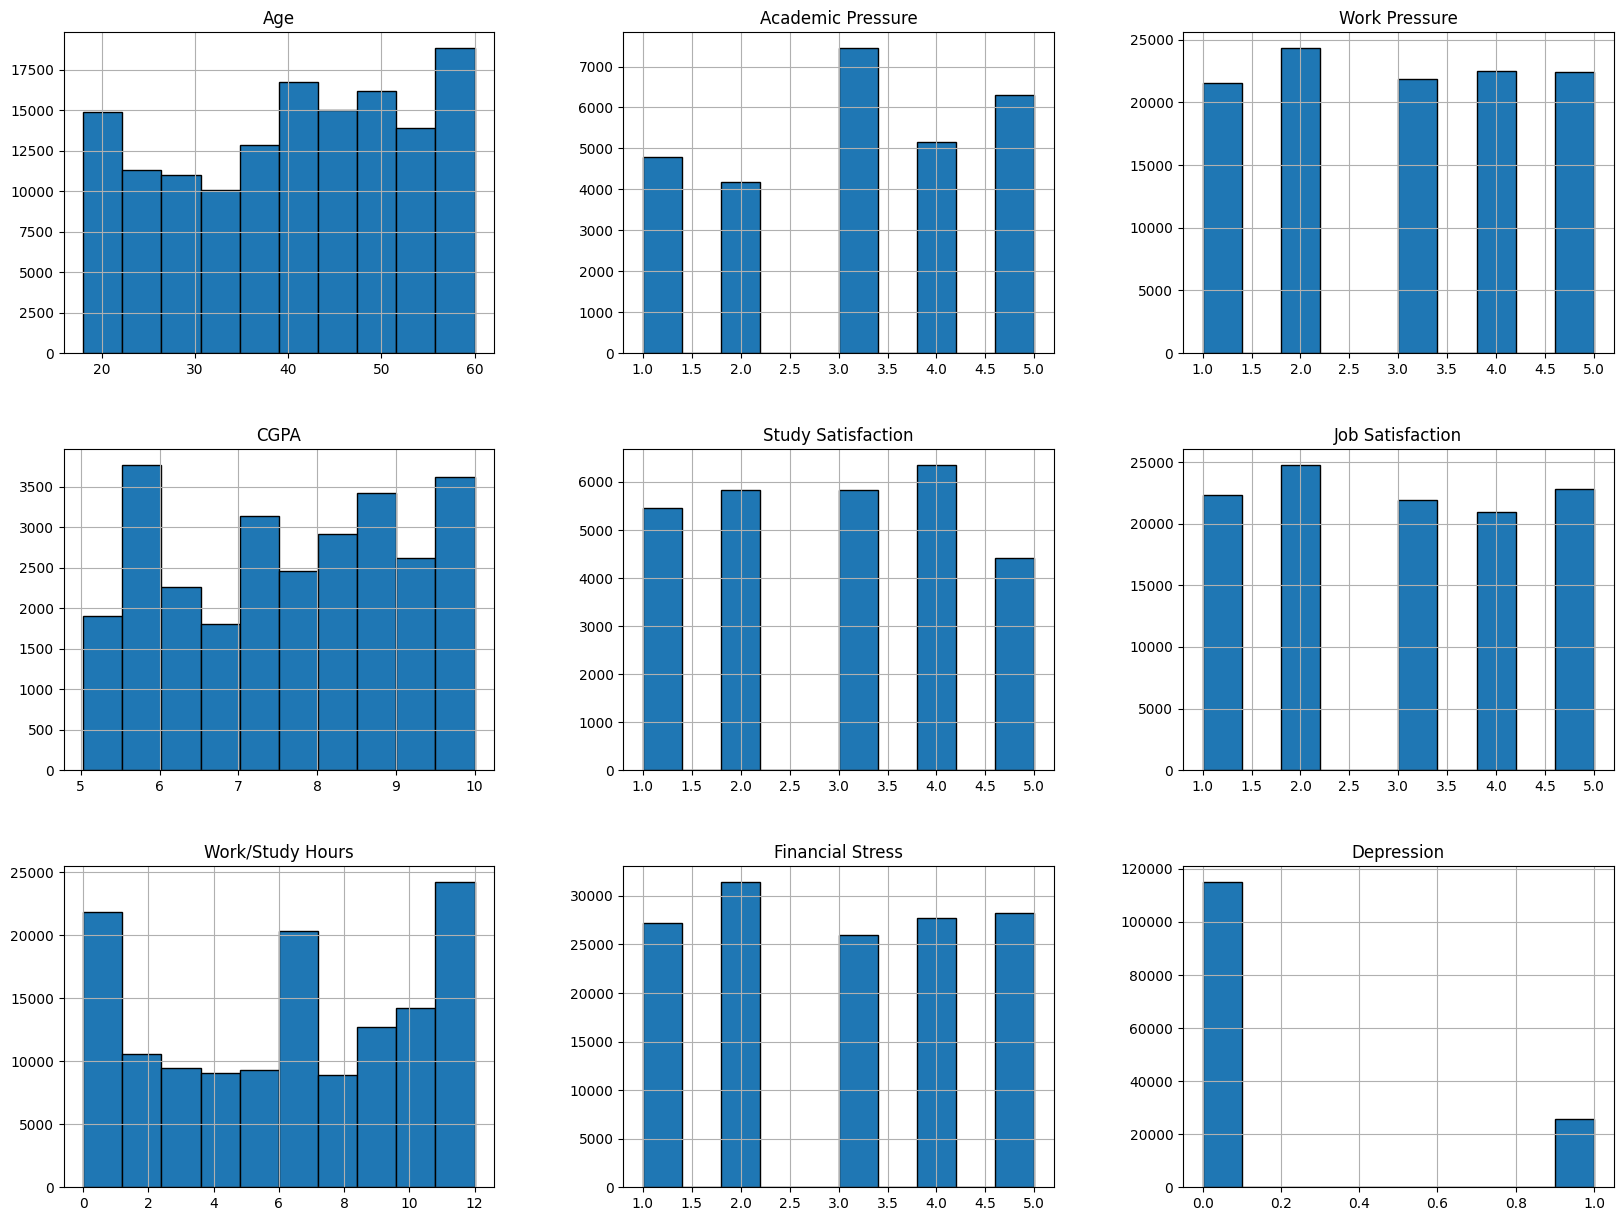

In [14]:
train_df.hist(figsize=(20,15),edgecolor='black');

In [15]:
#train_df.info()

In [16]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


### Target Variable

In [17]:
#train_df['Depression'].hist(figsize=(6,4));

In [18]:
#def cat_count_plot_dist(data,column,title=None,figsize=(15,10)):

In [19]:
def cat_plot_count_dist(data, column, title=None, figsize=(15,10)):
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=column, data=data)
    
    # Set title (use column name if title not provided)
    title = title or f'Distribution by {column}'
    plt.title(title, fontsize=16)
    
    # Set labels
    plt.xlabel(column, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    
    # Set tick sizes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add value labels on bars
    for i in ax.containers:
        ax.bar_label(i, fontsize=14, padding=10)
        
    plt.tight_layout()
    plt.show()

In [20]:
def plot_pie_distribution(data, column, explode=None, figsize=(6,6), title=None):
   # Get value counts
   counts = data[column].value_counts()
   
   # Set default explode if not provided 
   if explode is None:
       explode = tuple([0] * len(counts))
   
   # Set default title if not provided
   title = title or f'Distribution of {column}'
   
   plt.figure(figsize=figsize)
   plt.pie(counts.values, labels=counts.index,
           explode=explode, autopct='%1.1f%%', startangle=90)
   plt.axis('equal')
   plt.title(title, fontsize=16)
   plt.show()


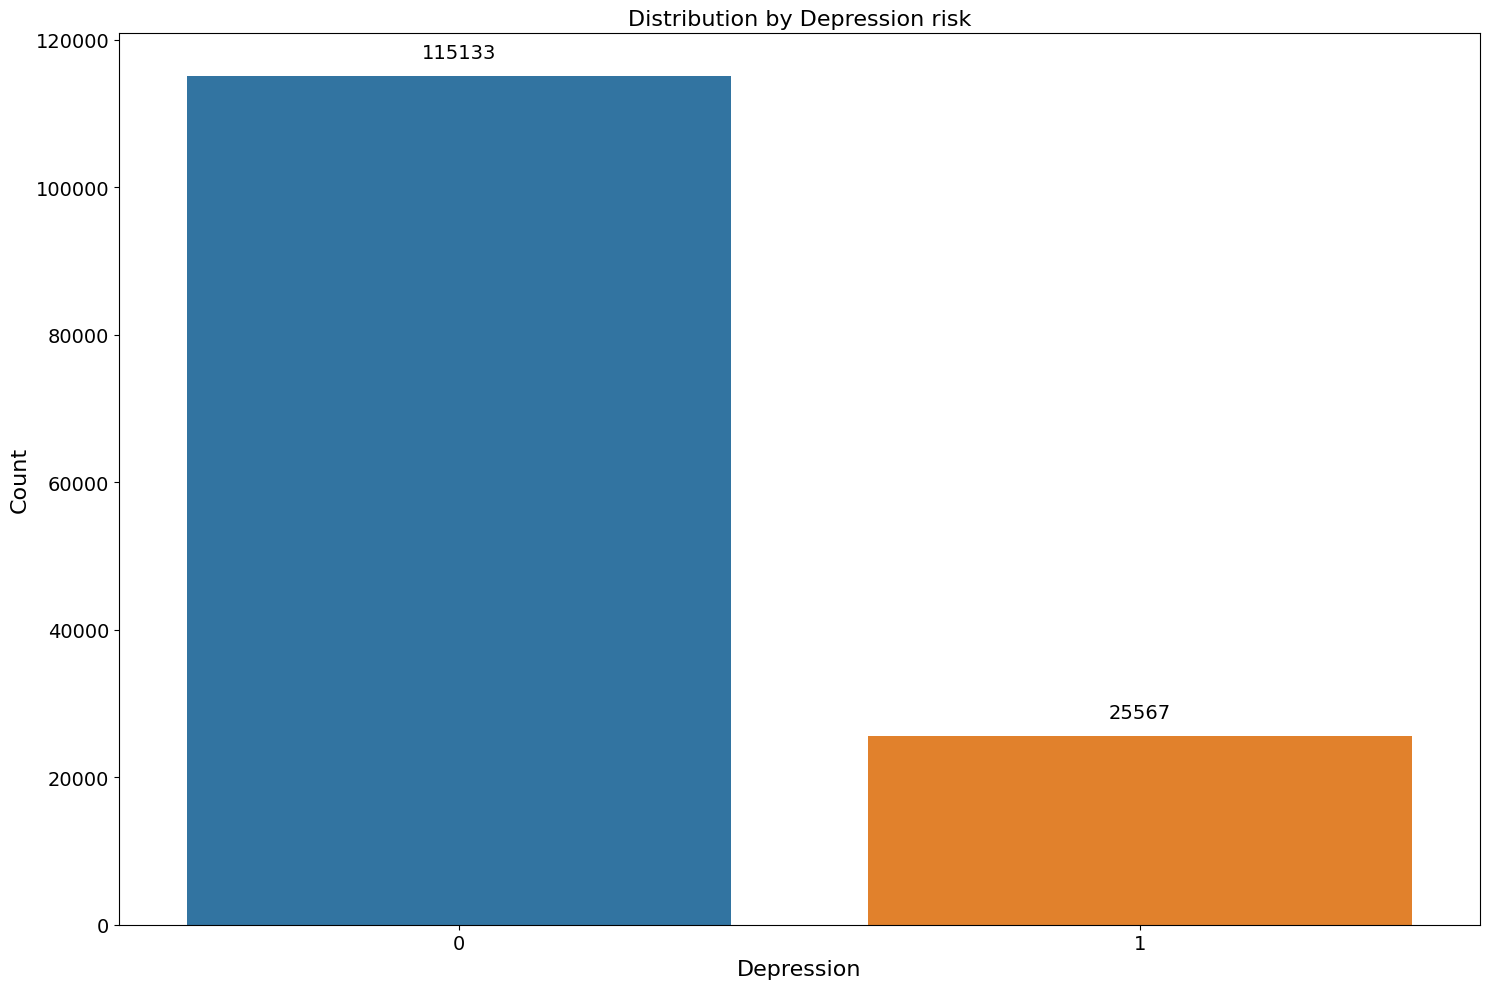

In [21]:
#cat_plot_count_dist(train_df, 'Depression', figsize=(12,8))
cat_plot_count_dist(train_df, 'Depression', 'Distribution by Depression risk')

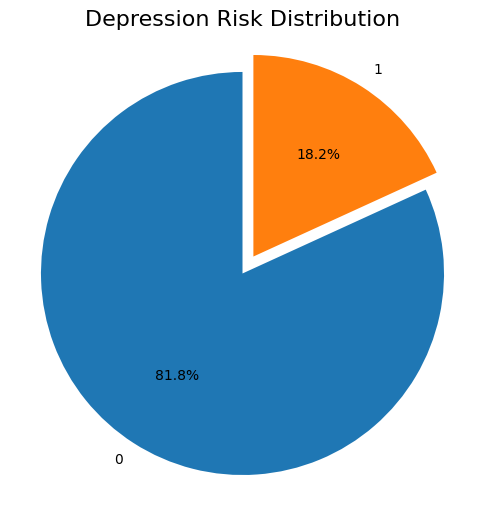

In [22]:
plot_pie_distribution(train_df, 'Depression', 
                    explode=(0,0.1), 
                    title='Depression Risk Distribution')

We can see from above that the dataset is imbalanced.

### Univariate Analysis

Let us take a look at the categorical variables shown by adding include=[object] below

In [23]:
train_df.describe(include=[object]).T

,count,unique,top,freq
Name,140700,422,Rohan,3178
Gender,140700,2,Male,77464
City,140700,98,Kalyan,6591
Working Professional or Student,140700,2,Working Professional,112799
Profession,104070,64,Teacher,24906
Sleep Duration,140700,36,Less than 5 hours,38784
Dietary Habits,140696,23,Moderate,49705
Degree,140698,115,Class 12,14729
Have you ever had suicidal thoughts ?,140700,2,No,71138
Family History of Mental Illness,140700,2,No,70758


#### Name

In [24]:
train_df['Name'].nunique()

422

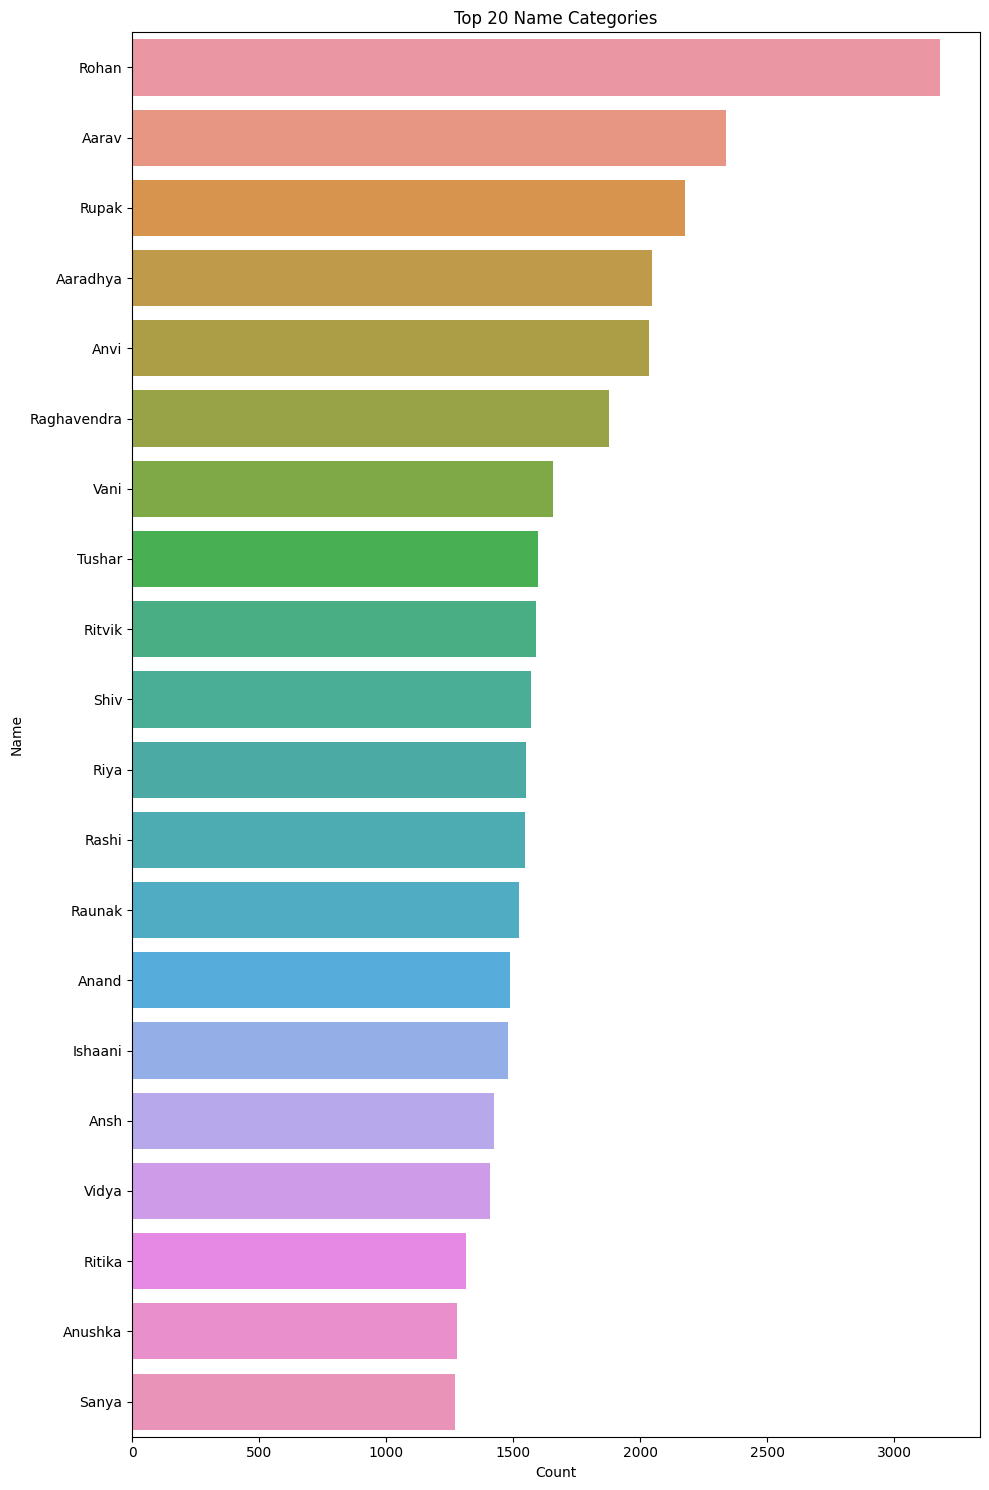

In [25]:
def plot_top_categories(data, column, top_n=20, figsize=(10,15)):
    # Get value counts and take top N
    top_values = data[column].value_counts().head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top {top_n} {column} Categories')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


plot_top_categories(train_df, 'Name', top_n=20)

It seems that Rohan in quite the popular name.

Personally i have a feeling name isnt a big influencing factor as you are named at before or at birth, but we can look at the model feature importance below for more conclusive evidence.

After taking a look at the feature importance for the various models below, it does seem to actually be an important variable. I wonder why name would be an important factor. I will try to look into this later on.

#### Gender

In [26]:
train_df['Gender'].unique(),train_df['Gender'].nunique()

(array(['Female', 'Male'], dtype=object), 2)

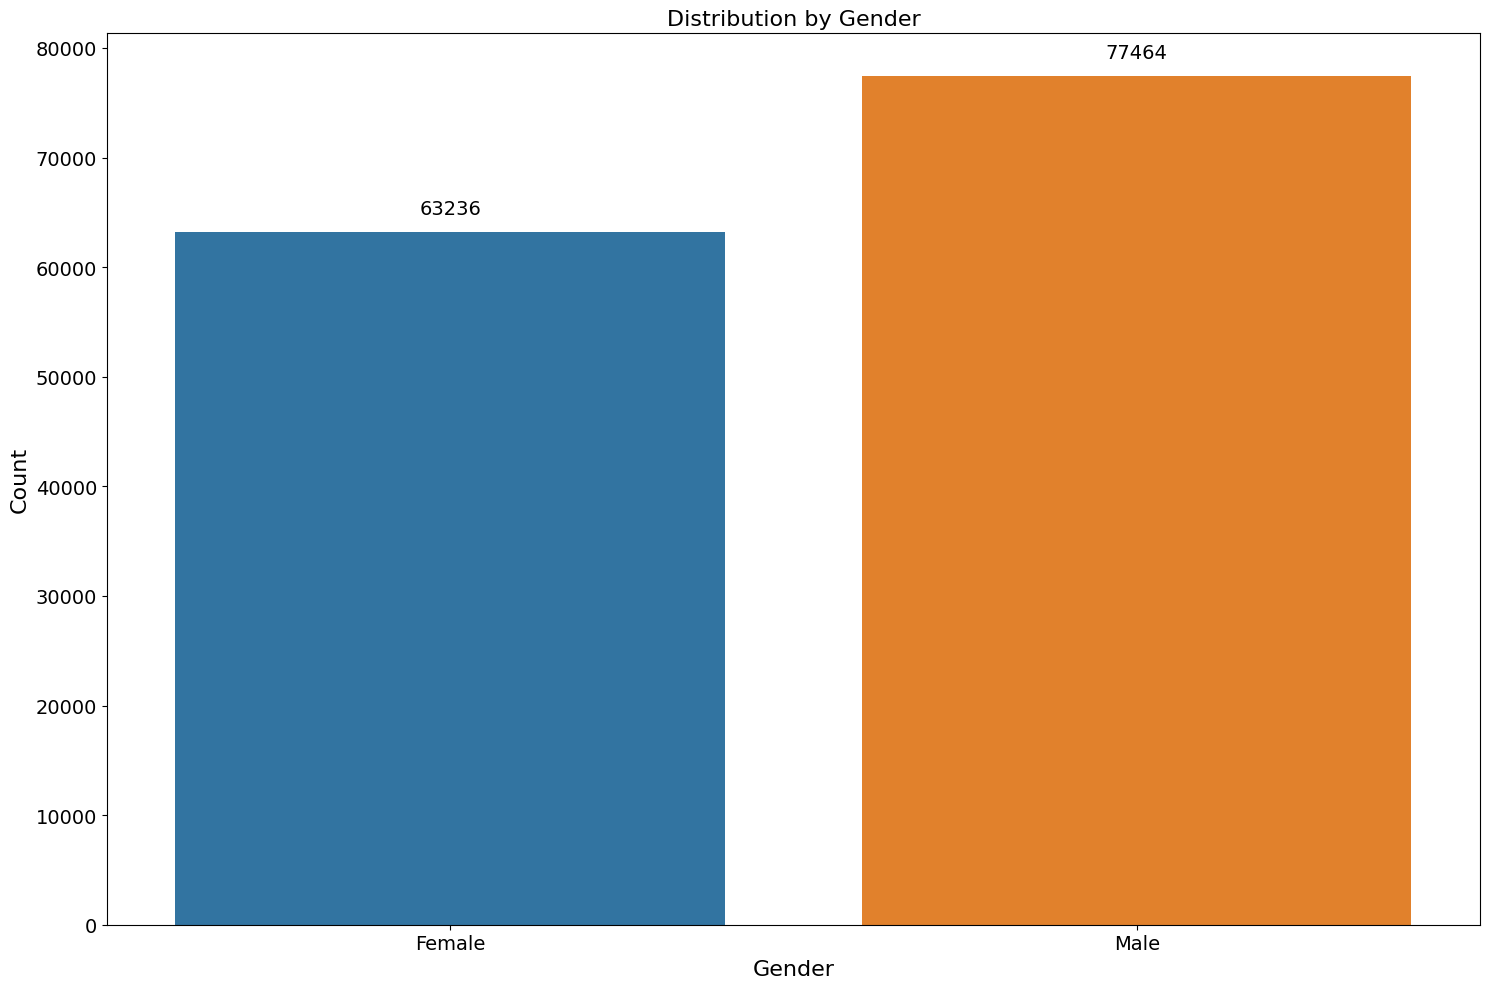

In [27]:
cat_plot_count_dist(train_df, 'Gender', 'Distribution by Gender')

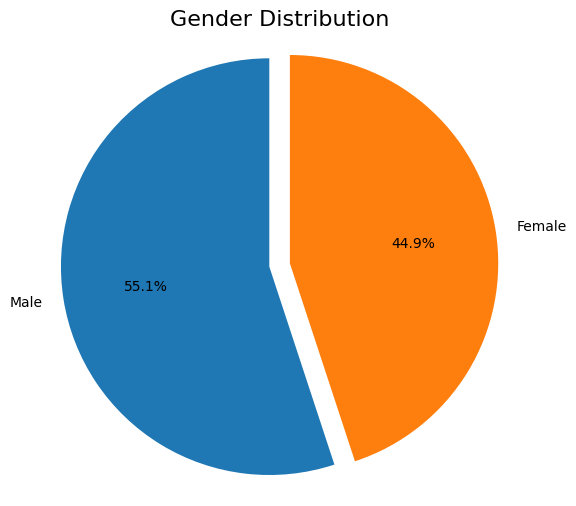

In [28]:
plot_pie_distribution(train_df, 'Gender', 
                    explode=(0,0.1), 
                    title='Gender Distribution')

The dataset has almost as many women as men potentially reducing the bias caused by class imbalance.

## Data Pre-processing with fast.ai



In [29]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Depression',
                   y_block=CategoryBlock(),
                   splits=splits)
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

I will explain what is going on above

- First we define categorical and continous variables
I use the fastai cont_cat_split function to separate my dataset variables into categorical and continous variables based of the cardinality of my column values.

We take an argument max card whose default is 20.If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continous and vice versa.

- Split into training and validation set
The RandomSplitter below separates the training set into a training and validation set based off the value of the argument valid_pct.

- Define a TabularPandas object.
Here we declare the continous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting and the type of problem we are optimizing for such as binary classification in this case.

- Create and define a dataloaders
This prepares our data for input into our neural network.Here we can define our batch size.

- Extract train and validation sets + their values.


In [30]:
cont_names,len(cont_names)

(['Age',
  'Academic Pressure',
  'Work Pressure',
  'CGPA',
  'Study Satisfaction',
  'Job Satisfaction',
  'Work/Study Hours',
  'Financial Stress'],
 8)

In [31]:
cat_names,len(cat_names)

(['Name',
  'Gender',
  'City',
  'Working Professional or Student',
  'Profession',
  'Sleep Duration',
  'Dietary Habits',
  'Degree',
  'Have you ever had suicidal thoughts ?',
  'Family History of Mental Illness',
  'Academic Pressure_na',
  'Work Pressure_na',
  'CGPA_na',
  'Study Satisfaction_na',
  'Job Satisfaction_na',
  'Financial Stress_na'],
 16)

In [32]:
train_df.shape,X_train.shape

((140700, 19), (112560, 24))

It seems the preprocessing steps from above result in new columns in my training data, X_train

# Models

In [33]:
xgb_params = {'seed':42}
lgbm_params = {'seed':42}
cat_params = {'random_seed':42}
rf_preds = {'random_state':42}

## Cross Validation function

In [34]:
def cross_val_predict(model_class, model_params=None, n_splits=5, random_state=42):
    if model_params is None:
        model_params = {}
    """
    Perform cross-validation using the fixed dataset and return predictions and scores.
    
    Parameters:
    - model_class: the model class (e.g., xgb.XGBClassifier)
    - model_params: dictionary of model parameters
    - n_splits: number of CV folds
    - random_state: random seed for reproducibility
    
    Returns:
    - oof_predictions: out-of-fold predictions on training set
    - submission_predictions: predictions on test_dl.xs
    - mean_score: mean accuracy score across folds
    - fold_scores: list of scores for each fold
    """
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize arrays to store results
    oof_predictions = np.zeros(len(X_train))  # Array for OOF predictions
    submission_predictions = np.zeros(len(test_dl.xs))  # Array for test predictions
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        # Split data for current fold
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Initialize and train model on current fold
        model_fold = model_class(**model_params)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred_fold = model_fold.predict(X_fold_val)
        
        # Store OOF predictions
        oof_predictions[val_index] = y_pred_fold
        
        # Get and accumulate test predictions
        submission_predictions += model_fold.predict(test_dl.xs) / n_splits
        
        # Calculate and store score
        cv_score = accuracy_score(y_fold_val, y_pred_fold)
        fold_scores.append(cv_score)
        
        print(f"Fold {fold} AUC: {cv_score:.6f}")
    
    # Calculate mean score
    mean_score = np.mean(fold_scores)
    print(f"\nMean AUC: {mean_score:.6f}")
    
    return oof_predictions, submission_predictions, mean_score, fold_scores

# Usage example:
#oof_preds, submission_preds, mean_score, fold_scores = cross_val_predict(
    #model_class=xgb.XGBClassifier
#)

# Create submission file
#submission_df = pd.DataFrame({
    #'id': test_df.index,  # adjust if you have different id column
    #'Depression': submission_preds
#})
#submission_df.to_csv('submission.csv', index=False)

# You can also analyze OOF predictions
#print("\nOOF Predictions Score:", accuracy_score(y_train, oof_preds))

## Deep learning - Neural Networks

In [35]:
learn = tabular_learner(dls, metrics=accuracy)

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0020892962347716093)

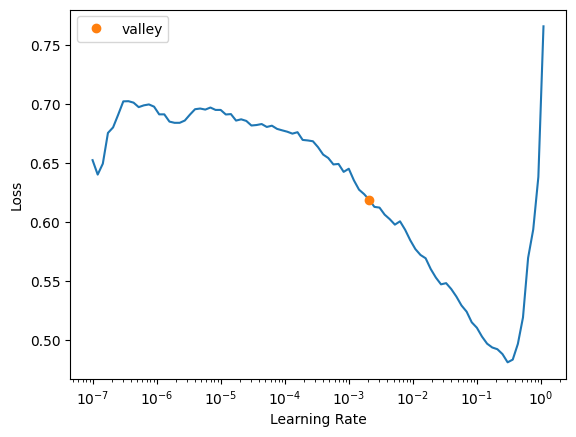

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.162818,0.164381,0.937313,00:29
1,0.172922,0.155475,0.937669,00:30
2,0.163253,0.158600,0.935963,00:29
3,0.144166,0.157091,0.936603,00:30
4,0.146153,0.157286,0.936496,00:29
5,0.141999,0.158176,0.937562,00:30
6,0.128761,0.162693,0.935359,00:29
7,0.136403,0.160767,0.935714,00:30
8,0.135011,0.162757,0.935146,00:29
9,0.136035,0.161852,0.935288,00:30


In [38]:
dl = test_dl

In [39]:
learn.save('nn_model_mental_health_v1')

Path('models/nn_model_mental_health_v1.pth')

In [40]:
#learn.load('nn_model_loan_approval_v1')  

In [41]:
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [42]:
a_preds.shape

torch.Size([93800, 2])

In [43]:
nn_preds_y.shape,sub_df.shape

(torch.Size([93800, 2]), (93800, 2))

In [44]:
final_preds = torch.round(a_preds).long()
final_preds

tensor([[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]])

In [45]:
final_preds.shape

torch.Size([93800, 2])

In [46]:
!rm submission.csv
#sub_df['Depression'] = final_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


## Gradient Boosting

In [47]:
# Parameters

## Random Forest

In [48]:
%%time
rf = RandomForestClassifier(1000, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = accuracy_score(y_test,rf_preds_x)
rf_score

CPU times: user 3min 24s, sys: 885 ms, total: 3min 25s
Wall time: 3min 26s


0.9358919687277896

In [49]:
rf_preds

tensor([0, 0, 0,  ..., 0, 1, 0], dtype=torch.int8)

In [50]:
rf_oof_preds, rf_submission_preds, rf_mean_score, rf_fold_scores = cross_val_predict(
    model_class=RandomForestClassifier
)

Fold 1 AUC: 0.934213
Fold 2 AUC: 0.940032
Fold 3 AUC: 0.933991
Fold 4 AUC: 0.938166
Fold 5 AUC: 0.935812

Mean AUC: 0.936443


In [51]:
rf_oof_preds

array([0., 0., 0., ..., 0., 1., 1.])

In [52]:
rf_submission_preds = torch.round(torch.tensor(rf_submission_preds)).long()
rf_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [53]:
 rf_mean_score

0.9364427860696518

In [54]:
rf_fold_scores

[0.9342128642501777,
 0.9400319829424307,
 0.9339907604832978,
 0.9381663113006397,
 0.9358120113717129]

In [55]:
rf_oof_preds.shape, rf_submission_preds.shape, rf_mean_score

((112560,), torch.Size([93800]), 0.9364427860696518)

Random forest feature importance

In [56]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [57]:
fi = rf_feat_importance(rf_model, X_train)
#fi[:10]
fi

,cols,imp
15,Financial Stress_na,1.434368e-07
1,Gender,5.379754e-03
9,Family History of Mental Illness,5.614127e-03
5,Sleep Duration,1.308341e-02
20,Study Satisfaction,1.673922e-02
6,Dietary Habits,2.005531e-02
13,Study Satisfaction_na,2.148134e-02
19,CGPA,2.151118e-02
7,Degree,2.350665e-02
21,Job Satisfaction,2.465854e-02


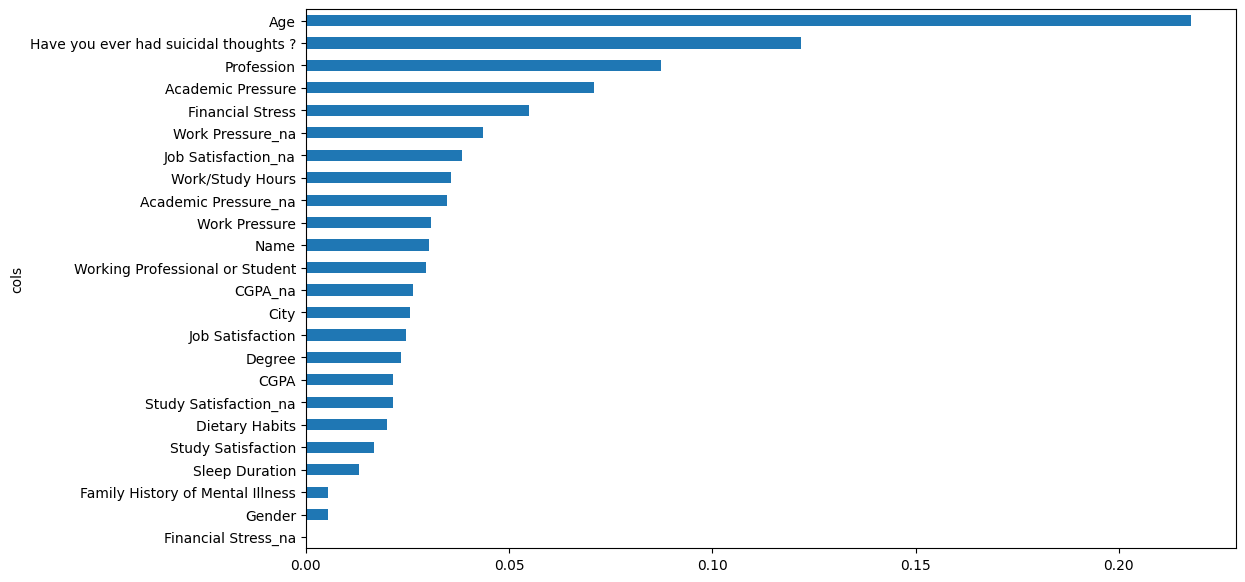

In [58]:
#feature importance visualization
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#plot_fi(fi[:30]);
plot_fi(fi);

In [59]:
!rm submission.csv
#sub_df['Depression'] = rf_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


## XGBoost

#### Single Fold

In [60]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = accuracy_score(y_test,xgb_preds_x)
xgb_score

CPU times: user 4.45 s, sys: 31 ms, total: 4.48 s
Wall time: 2.29 s


0.9381307746979389

In [61]:
xgb_oof_preds, xgb_submission_preds, xgb_mean_score, xgb_fold_scores = cross_val_predict(
    model_class=xgb.XGBClassifier,
    model_params = xgb_params
)

Fold 1 AUC: 0.935723
Fold 2 AUC: 0.940476
Fold 3 AUC: 0.936167
Fold 4 AUC: 0.938833
Fold 5 AUC: 0.935768

Mean AUC: 0.937393


In [62]:
xgb_oof_preds

array([0., 0., 0., ..., 0., 1., 1.])

In [63]:
xgb_submission_preds = torch.round(torch.tensor(xgb_submission_preds)).long()
xgb_submission_preds 

tensor([0, 0, 0,  ..., 0, 1, 0])

In [64]:
xgb_mean_score

0.9373933901918976

In [65]:
xgb_fold_scores

[0.935723169864961,
 0.9404761904761905,
 0.9361673773987207,
 0.9388326226012793,
 0.9357675906183369]

In [66]:
xgb_oof_preds.shape, xgb_submission_preds.shape, xgb_mean_score
#fold_scores.shape

((112560,), torch.Size([93800]), 0.9373933901918976)

In [67]:
!rm submission.csv
#sub_df['Depression'] = submission_preds 
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


In [68]:
#%%time
#K_FOLDS = 10  # Number of folds for cross-validation
#skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
#xgb_fold_scores = []

# Array to store out-of-fold predictions
#oof_predictions = np.zeros(len(X_train))

#for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    #X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    #y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    #xgb_model_fold = xgb.XGBClassifier()
    #xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    #y_pred_fold = xgb_model_fold.predict(X_fold_val)
    #y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    #xgb_cv_score = accuracy_score(y_fold_val, y_pred_fold)
    #xgb_fold_scores.append(xgb_cv_score)
    
    #print(f"Fold {fold} AUC: {xgb_cv_score}")

# Calculate and print the mean score across all folds
#xgb_mean_score = np.mean(xgb_fold_scores)
#print(f"Mean AUC: {xgb_mean_score}")

Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

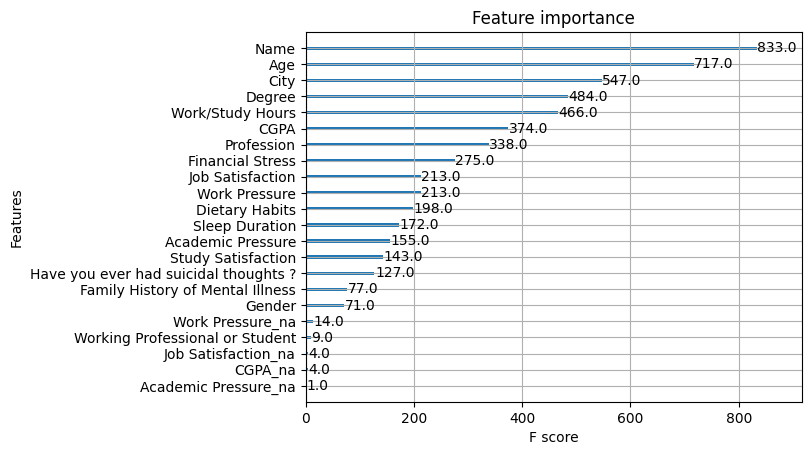

In [69]:
plot_importance(xgb_model)

## LGBM

In [70]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier()
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
#lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = accuracy_score(y_test,lgbm_preds_x)
lgbm_score

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20425, number of negative: 92135
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 112560, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181459 -> initscore=-1.506495
[LightGBM] [Info] Start training from score -1.506495
CPU times: user 4.74 s, sys: 77.5 ms, total: 4.82 s
Wall time: 2.53 s


0.9388059701492537

In [71]:
lgbm_oof_preds, lgbm_submission_preds, lgbm_mean_score, lgbm_fold_scores = cross_val_predict(
    model_class=lgb.LGBMClassifier,
    model_params = lgbm_params
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16340, number of negative: 73708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 90048, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181459 -> initscore=-1.506495
[LightGBM] [Info] Start training from score -1.506495
Fold 1 AUC: 0.938388
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16340, number of negative: 73708
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

In [72]:
lgbm_oof_preds

array([0., 0., 0., ..., 0., 1., 1.])

In [73]:
lgbm_submission_preds = torch.round(torch.tensor(lgbm_submission_preds)).long()
lgbm_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [74]:
lgbm_mean_score

0.9387171286425018

In [75]:
lgbm_fold_scores

[0.9383884150675196,
 0.9418976545842217,
 0.9363450604122245,
 0.939632196162047,
 0.937322316986496]

In [76]:
lgbm_oof_preds.shape, lgbm_submission_preds.shape, lgbm_mean_score

((112560,), torch.Size([93800]), 0.9387171286425018)

In [77]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgb_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    lgb_model_fold = lgb.LGBMClassifier()
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = lgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    lgb_cv_score = accuracy_score(y_fold_val, lgb_model_fold.predict(X_fold_val))
    lgb_fold_scores.append(lgb_cv_score)
    
    print(f"Fold {fold} AUC: {lgb_cv_score}")

lgb_mean_score = np.mean(lgb_fold_scores)
print(f"Mean AUC: {lgb_mean_score}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18383, number of negative: 82921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 101304, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181464 -> initscore=-1.506462
[LightGBM] [Info] Start training from score -1.506462
Fold 1 AUC: 0.9379886282871357
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18383, number of negative: 82921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

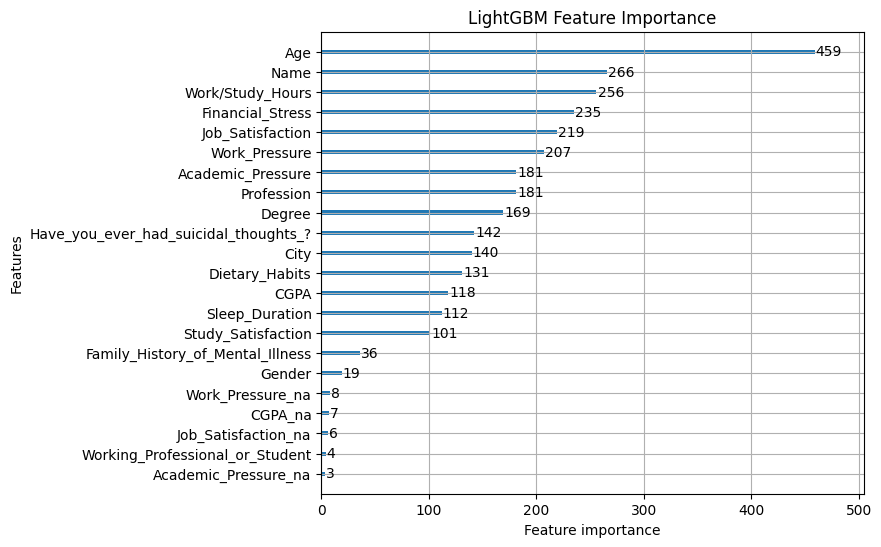

In [78]:
# Plot feature importance without using Gain or split
lgb.plot_importance(lgbm_model, figsize=(7,6), title="LightGBM Feature Importance")
#plt.title('LGBM Feature Importance')
#plt.tight_layout()
plt.show()

## CatBoost

In [79]:
%%time
#using full ds
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(X_train, y_train, verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = accuracy_score(y_test,cat_preds_x)
cat_score

CPU times: user 1min 26s, sys: 6.04 s, total: 1min 32s
Wall time: 23.9 s


0.9391257995735608

In [80]:
cat_oof_preds, cat_submission_preds, cat_mean_score, cat_fold_scores = cross_val_predict(
    model_class=CatBoostClassifier,
    model_params = cat_params
)

Learning rate set to 0.070387
0:	learn: 0.5768230	total: 22.8ms	remaining: 22.8s
1:	learn: 0.4883576	total: 42.5ms	remaining: 21.2s
2:	learn: 0.4218067	total: 63.1ms	remaining: 21s
3:	learn: 0.3717020	total: 84.1ms	remaining: 20.9s
4:	learn: 0.3339184	total: 105ms	remaining: 20.9s
5:	learn: 0.3059001	total: 126ms	remaining: 20.8s
6:	learn: 0.2811421	total: 147ms	remaining: 20.8s
7:	learn: 0.2621515	total: 167ms	remaining: 20.7s
8:	learn: 0.2467060	total: 187ms	remaining: 20.6s
9:	learn: 0.2346316	total: 210ms	remaining: 20.8s
10:	learn: 0.2246807	total: 230ms	remaining: 20.7s
11:	learn: 0.2166879	total: 251ms	remaining: 20.7s
12:	learn: 0.2106446	total: 271ms	remaining: 20.6s
13:	learn: 0.2052876	total: 290ms	remaining: 20.5s
14:	learn: 0.2012148	total: 310ms	remaining: 20.4s
15:	learn: 0.1971305	total: 330ms	remaining: 20.3s
16:	learn: 0.1939936	total: 350ms	remaining: 20.3s
17:	learn: 0.1899956	total: 371ms	remaining: 20.2s
18:	learn: 0.1875472	total: 391ms	remaining: 20.2s
19:	learn

In [81]:
cat_oof_preds

array([0., 0., 0., ..., 0., 1., 1.])

In [82]:
cat_submission_preds = torch.round(torch.tensor(cat_submission_preds)).long()
cat_submission_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [83]:
cat_mean_score

0.9393479033404406

In [84]:
cat_fold_scores

[0.9378109452736318,
 0.9421641791044776,
 0.9369669509594882,
 0.9405206112295664,
 0.939276830135039]

In [85]:
cat_oof_preds.shape, cat_submission_preds.shape, cat_mean_score

((112560,), torch.Size([93800]), 0.9393479033404406)

In [86]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    cat_model_fold = CatBoostClassifier()
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    cat_cv_score = accuracy_score(y_fold_val, cat_model_fold.predict(X_fold_val))
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} AUC: {cat_cv_score}")

catboost_mean_score = np.mean(cat_fold_scores)
print(f"Mean AUC: {catboost_mean_score}")

Learning rate set to 0.074018
0:	learn: 0.5742744	total: 22.8ms	remaining: 22.8s
1:	learn: 0.4839629	total: 44.2ms	remaining: 22.1s
2:	learn: 0.4175291	total: 66ms	remaining: 21.9s
3:	learn: 0.3649911	total: 89.1ms	remaining: 22.2s
4:	learn: 0.3262904	total: 112ms	remaining: 22.3s
5:	learn: 0.2979499	total: 133ms	remaining: 22.1s
6:	learn: 0.2764948	total: 155ms	remaining: 22s
7:	learn: 0.2574962	total: 178ms	remaining: 22.1s
8:	learn: 0.2425695	total: 205ms	remaining: 22.6s
9:	learn: 0.2320548	total: 228ms	remaining: 22.5s
10:	learn: 0.2225854	total: 250ms	remaining: 22.5s
11:	learn: 0.2147837	total: 272ms	remaining: 22.4s
12:	learn: 0.2076494	total: 294ms	remaining: 22.3s
13:	learn: 0.2032401	total: 314ms	remaining: 22.1s
14:	learn: 0.1991474	total: 336ms	remaining: 22.1s
15:	learn: 0.1947911	total: 358ms	remaining: 22s
16:	learn: 0.1909027	total: 380ms	remaining: 22s
17:	learn: 0.1882522	total: 398ms	remaining: 21.7s
18:	learn: 0.1855493	total: 424ms	remaining: 21.9s
19:	learn: 0.18

In [87]:
feature_importance = cat_model.get_feature_importance()
feature_names = train_df.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: Name, Importance: 4.66
Feature: Gender, Importance: 0.42
Feature: Age, Importance: 2.61
Feature: City, Importance: 0.01
Feature: Working Professional or Student, Importance: 4.55
Feature: Profession, Importance: 2.20
Feature: Academic Pressure, Importance: 2.99
Feature: Work Pressure, Importance: 2.74
Feature: CGPA, Importance: 14.58
Feature: Study Satisfaction, Importance: 0.49
Feature: Job Satisfaction, Importance: 0.07
Feature: Sleep Duration, Importance: 0.13
Feature: Dietary Habits, Importance: 0.12
Feature: Degree, Importance: 0.57
Feature: Have you ever had suicidal thoughts ?, Importance: 0.22
Feature: Work/Study Hours, Importance: 0.00
Feature: Financial Stress, Importance: 29.97
Feature: Family History of Mental Illness, Importance: 3.97
Feature: Depression, Importance: 7.86


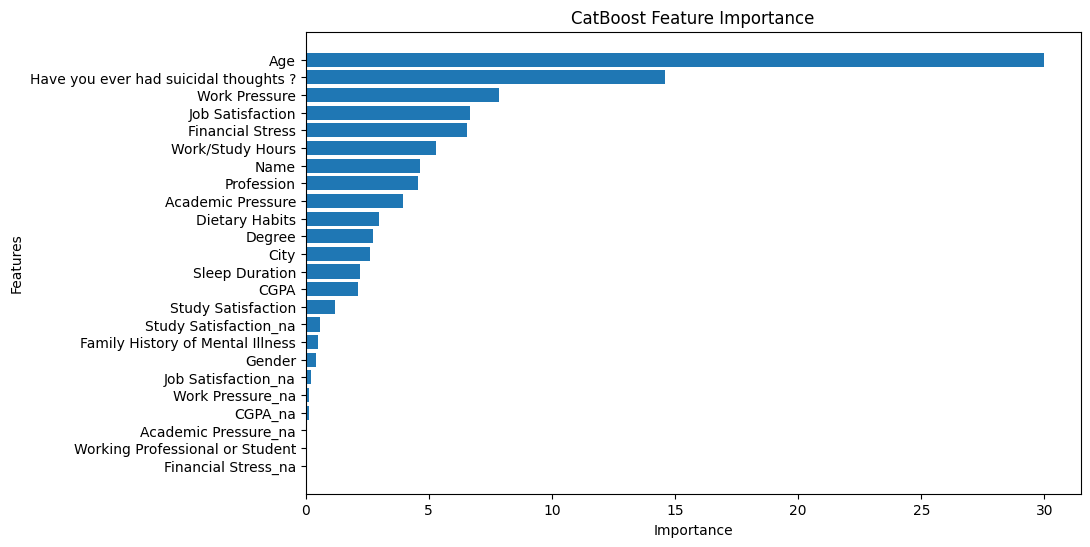

In [88]:
#importances = cat_model.get_feature_importance(type='PredictionValuesChange')
importances = cat_model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [89]:
!rm submission.csv
#sub_df['Depression'] = cat_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

rm: cannot remove 'submission.csv': No such file or directory


# Ensembling

## Averaging

### Scoring

In [90]:
def average_preds_score(preds_a,preds_b):
    average_preds = (torch.round(preds_a + preds_b)/2).long()
    preds_score = accuracy_score(y_test,average_preds)
    print(f"Average_score:{preds_score}")
    return preds_score

In [91]:
xgb_lgbm_score = average_preds_score(xgb_preds_x,lgbm_preds_x)
xgb_lgbm_score

Average_score:0.9386638237384506


0.9386638237384506

In [92]:
cat_lgbm_score = average_preds_score(cat_preds_x,lgbm_preds_x)
cat_lgbm_score

Average_score:0.9390191897654584


0.9390191897654584

In [93]:
cat_xgb_score = average_preds_score(cat_preds_x,xgb_preds_x)
cat_xgb_score

Average_score:0.9384861407249467


0.9384861407249467

In [94]:
cat_rf_score = average_preds_score(cat_preds_x,rf_preds_x)
cat_rf_score

Average_score:0.9364250177683013


0.9364250177683013

In [95]:
lgbm_rf_score = average_preds_score(lgbm_preds_x,rf_preds_x)
lgbm_rf_score

Average_score:0.9359630419331912


0.9359630419331912

In [96]:
xgb_rf_score = average_preds_score(xgb_preds_x,rf_preds_x)
xgb_rf_score

Average_score:0.9356787491115849


0.9356787491115849

In [97]:
cat_xgb_lgbm_preds_x = (cat_preds_x + xgb_preds_x + lgbm_preds_x)/3
cat_xgb_lgbm_preds_x = torch.round(cat_xgb_lgbm_preds_x).long()
cat_xgb_lgbm_score = accuracy_score(y_test,cat_xgb_lgbm_preds_x)

In [98]:
cat_xgb_lgbm_rf_preds_x = (cat_preds_x + xgb_preds_x + lgbm_preds_x + rf_preds_x)/4
cat_xgb_lgbm_rf_preds_x = torch.round(cat_xgb_lgbm_rf_preds_x).long()
cat_xgb_lgbm_rf_score = accuracy_score(y_test,cat_xgb_lgbm_rf_preds_x)

## Submission

In [99]:
def average_preds_sub(preds_a,preds_b):
    average_preds_sub = (torch.round(preds_a + preds_b)/2).long()
    return average_preds_sub

In [100]:
cat_lgbm_preds = average_preds_sub(cat_preds,lgbm_preds)
cat_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [101]:
cat_xgb_preds = average_preds_sub(cat_preds,xgb_preds)
cat_xgb_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [102]:
xgb_lgbm_preds = average_preds_sub(xgb_preds,lgbm_preds)
xgb_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [103]:
cat_xgb_lgbm_preds = (cat_preds + xgb_preds + lgbm_preds)/3
cat_xgb_lgbm_preds = torch.round(cat_xgb_lgbm_preds).long()
cat_xgb_lgbm_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [104]:
cat_xgb_lgbm_rf_preds = (cat_preds + xgb_preds + lgbm_preds + rf_preds)/4
cat_xgb_lgbm_rf_preds = torch.round(cat_xgb_lgbm_rf_preds).long()
cat_xgb_lgbm_rf_preds

tensor([0, 0, 0,  ..., 0, 1, 0])

In [105]:
#!rm submission.csv
#sub_df['Depression'] = cat_xgb_lgbm_rf_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

## Hill Climbing

Below, i try to create a weighted ensemble using hill climbing, first i shall try for lgbm and catboost which are my best performing models so far

In [106]:
# Get class predictions for only CatBoost and LightGBM
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    # For class predictions, round the weighted sum
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    return valid_preds, test_preds, weights, best_score

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print(f"Optimized weights: {final_weights}")
print(f"Best validation accuracy: {best_score}")

# Compare scores
print("\nModel Scores:")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)

Optimized weights: [0.4994995 0.5005005]
Best validation accuracy: 0.9391257995735608

Model Scores:
LightGBM: 0.9388059701492537
CatBoost: 0.9391257995735608
Hill Climbing Ensemble: 0.9391257995735608


Hill climbing and catboost score seem to be the same, did it just selcet cat scores ?

add something to show model contribution percentage

In [107]:
# Get class predictions for only CatBoost and LightGBM
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    # Calculate percentage contributions
    percentages = {
        'LightGBM': weights[0] * 100,
        'CatBoost': weights[1] * 100
    }
    
    return valid_preds, test_preds, weights, best_score, percentages

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score, model_percentages = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print("\nModel Contributions:")
for model, percentage in model_percentages.items():
    print(f"{model}: {percentage:.2f}%")

print(f"\nBest validation accuracy: {best_score}")

# Compare scores
print("\nIndividual Model Scores:")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)


Model Contributions:
LightGBM: 49.95%
CatBoost: 50.05%

Best validation accuracy: 0.9391257995735608

Individual Model Scores:
LightGBM: 0.9388059701492537
CatBoost: 0.9391257995735608
Hill Climbing Ensemble: 0.9391257995735608


xgb + lgbm + cat

In [108]:
# Get both probabilities and class predictions
xgb_preds = tensor(xgb_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
cat_preds = tensor(cat_model.predict(test_dl.xs))

# Validation predictions
xgb_valid_preds = tensor(xgb_model.predict(X_test))
lgbm_valid_preds = tensor(lgbm_model.predict(X_test))
cat_valid_preds = tensor(cat_model.predict(X_test))

# Create validation DataFrame for hill climbing
valid_ensemble = pd.DataFrame({
    'xgb': xgb_valid_preds,
    'lgbm': lgbm_valid_preds,
    'cat': cat_valid_preds
})

# Create test DataFrame for hill climbing
test_ensemble = pd.DataFrame({
    'xgb': xgb_preds,
    'lgbm': lgbm_preds,
    'cat': cat_preds
})

def climb_hill(train_preds, test_preds, y_true, precision=0.001, max_iter=1000):
    n_models = train_preds.shape[1]
    weights = np.ones(n_models) / n_models  # Start with equal weights
    
    # For class predictions, round the weighted sum
    best_preds = np.round(train_preds @ weights).astype(int)
    best_score = accuracy_score(y_true, best_preds)
    improved = True
    iter_count = 0
    
    while improved and iter_count < max_iter:
        improved = False
        iter_count += 1
        
        for i in range(n_models):
            # Try increasing weight
            new_weights = weights.copy()
            new_weights[i] += precision
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
                continue
                
            # Try decreasing weight
            new_weights = weights.copy()
            new_weights[i] = max(0, new_weights[i] - precision)
            new_weights = new_weights / new_weights.sum()  # Normalize
            
            new_preds = np.round(train_preds @ new_weights).astype(int)
            new_score = accuracy_score(y_true, new_preds)
            
            if new_score > best_score:
                weights = new_weights
                best_score = new_score
                improved = True
    
    # Get final predictions for both validation and test
    valid_preds = np.round(train_preds @ weights).astype(int)
    test_preds = np.round(test_preds @ weights).astype(int)
    
    return valid_preds, test_preds, weights, best_score

# Apply hill climbing
valid_preds, optimized_test_preds, final_weights, best_score = climb_hill(
    valid_ensemble.values, 
    test_ensemble.values, 
    y_test
)

print(f"Optimized weights: {final_weights}")
print(f"Best validation accuracy: {best_score}")

# Compare scores
print("\nModel Scores:")
print(f"XGBoost: {xgb_score}")
print(f"LightGBM: {lgbm_score}")
print(f"CatBoost: {cat_score}")
print(f"Hill Climbing Ensemble: {best_score}")

# Create submission with optimized predictions
sub_df['Depression'] = optimized_test_preds
sub_df.to_csv('submission.csv', index=False)

Optimized weights: [0.33333333 0.33333333 0.33333333]
Best validation accuracy: 0.9398365316275764

Model Scores:
XGBoost: 0.9381307746979389
LightGBM: 0.9388059701492537
CatBoost: 0.9391257995735608
Hill Climbing Ensemble: 0.9398365316275764


In [109]:
sub = pd.read_csv('submission.csv')
sub

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


## Stacking

In [110]:
stacking_estimators = [
    ('cat_boost',cat_model),
    #('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

stacking_classifier_cat_xgb_lgbm= StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
#stacking_classifier_cat_lgbm= StackingClassifier(
    #estimators=stacking_estimators,
    #final_estimator=lgb.LGBMClassifier(**lgbm_params),
    #cv=5
#)
stacking_classifier_cat_xgb_lgbm.fit(X_train, y_train)


stacking_preds_cat_xgb_lgbm = (stacking_classifier_cat_xgb_lgbm.predict(test_dl.xs))
stacking_preds_cat_xgb_lgbm_x = stacking_classifier_cat_xgb_lgbm.predict(X_test)

stacking_score_cat_xgb_lgbm = accuracy_score(y_test, stacking_preds_cat_xgb_lgbm_x)

print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_xgb_lgbm}")

Learning rate set to 0.077424
0:	learn: 0.5699947	total: 35.4ms	remaining: 35.4s
1:	learn: 0.4793677	total: 66ms	remaining: 32.9s
2:	learn: 0.4082038	total: 97.9ms	remaining: 32.5s
3:	learn: 0.3613070	total: 130ms	remaining: 32.3s
4:	learn: 0.3199521	total: 162ms	remaining: 32.2s
5:	learn: 0.2908878	total: 196ms	remaining: 32.5s
6:	learn: 0.2686575	total: 228ms	remaining: 32.4s
7:	learn: 0.2530356	total: 259ms	remaining: 32.1s
8:	learn: 0.2375509	total: 291ms	remaining: 32s
9:	learn: 0.2264364	total: 323ms	remaining: 32s
10:	learn: 0.2170646	total: 356ms	remaining: 32s
11:	learn: 0.2099748	total: 388ms	remaining: 31.9s
12:	learn: 0.2035891	total: 421ms	remaining: 32s
13:	learn: 0.1988310	total: 453ms	remaining: 31.9s
14:	learn: 0.1953581	total: 481ms	remaining: 31.6s
15:	learn: 0.1922530	total: 511ms	remaining: 31.4s
16:	learn: 0.1894220	total: 541ms	remaining: 31.3s
17:	learn: 0.1854899	total: 573ms	remaining: 31.2s
18:	learn: 0.1828115	total: 605ms	remaining: 31.2s
19:	learn: 0.18069

In [111]:
stacking_preds_cat_xgb_lgbm.shape

(93800,)

In [112]:
stacking_preds_cat_xgb_lgbm = torch.tensor(stacking_preds_cat_xgb_lgbm)

In [113]:
stacking_estimators = [
    ('cat_boost',cat_model),
    ('rf',rf_model),
    ('lgbm',lgbm_model),
    ('xgb',xgb_model),
]

stacking_classifier_cat_xgb_lgbm_rf= StackingClassifier(
    estimators=stacking_estimators,
    final_estimator=LogisticRegression(),
    cv=5
)
#stacking_classifier_cat_lgbm= StackingClassifier(
    #estimators=stacking_estimators,
    #final_estimator=lgb.LGBMClassifier(**lgbm_params),
    #cv=5
#)
stacking_classifier_cat_xgb_lgbm_rf.fit(X_train, y_train)


stacking_preds_cat_xgb_lgbm_rf = (stacking_classifier_cat_xgb_lgbm_rf.predict(test_dl.xs))
stacking_preds_cat_xgb_lgbm_rf_x = stacking_classifier_cat_xgb_lgbm_rf.predict(X_test)

stacking_score_cat_xgb_lgbm_rf = accuracy_score(y_test, stacking_preds_cat_xgb_lgbm_rf_x)

print(f"Final Stacking Classifier Accuracy on test set: {stacking_score_cat_xgb_lgbm_rf}")

Learning rate set to 0.077424
0:	learn: 0.5699947	total: 25.6ms	remaining: 25.6s
1:	learn: 0.4793677	total: 49.1ms	remaining: 24.5s
2:	learn: 0.4082038	total: 74.6ms	remaining: 24.8s
3:	learn: 0.3613070	total: 99.4ms	remaining: 24.8s
4:	learn: 0.3199521	total: 126ms	remaining: 25s
5:	learn: 0.2908878	total: 155ms	remaining: 25.7s
6:	learn: 0.2686575	total: 182ms	remaining: 25.9s
7:	learn: 0.2530356	total: 209ms	remaining: 25.9s
8:	learn: 0.2375509	total: 233ms	remaining: 25.7s
9:	learn: 0.2264364	total: 258ms	remaining: 25.5s
10:	learn: 0.2170646	total: 282ms	remaining: 25.4s
11:	learn: 0.2099748	total: 307ms	remaining: 25.3s
12:	learn: 0.2035891	total: 332ms	remaining: 25.2s
13:	learn: 0.1988310	total: 356ms	remaining: 25.1s
14:	learn: 0.1953581	total: 377ms	remaining: 24.8s
15:	learn: 0.1922530	total: 400ms	remaining: 24.6s
16:	learn: 0.1894220	total: 425ms	remaining: 24.5s
17:	learn: 0.1854899	total: 449ms	remaining: 24.5s
18:	learn: 0.1828115	total: 472ms	remaining: 24.4s
19:	learn

In [114]:
stacking_score_cat_xgb_lgbm,stacking_score_cat_xgb_lgbm_rf

(0.9389481165600568, 0.938592750533049)

In [115]:
#!rm submission.csv
#sub_df['Depression'] = stacking_preds_cat_xgb_lgbm
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#sub

In the next version ill try out voting and compare performance

### Voting

In [116]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='soft')



voting_clf.fit(X_train, y_train)

voting_predictions = voting_clf.predict(test_dl.xs)
voting_predictions_x = voting_clf.predict(X_test)

# Calculate the accuracy score
voting_accuracy_soft = accuracy_score(y_test, voting_predictions_x)
#print(f"Accuracy: {voting_accuracy:.6f}")

Learning rate set to 0.077424
0:	learn: 0.5699947	total: 25.5ms	remaining: 25.5s
1:	learn: 0.4793677	total: 48.8ms	remaining: 24.4s
2:	learn: 0.4082038	total: 73.9ms	remaining: 24.6s
3:	learn: 0.3613070	total: 98.6ms	remaining: 24.6s
4:	learn: 0.3199521	total: 123ms	remaining: 24.4s
5:	learn: 0.2908878	total: 148ms	remaining: 24.5s
6:	learn: 0.2686575	total: 173ms	remaining: 24.5s
7:	learn: 0.2530356	total: 198ms	remaining: 24.5s
8:	learn: 0.2375509	total: 222ms	remaining: 24.5s
9:	learn: 0.2264364	total: 246ms	remaining: 24.4s
10:	learn: 0.2170646	total: 271ms	remaining: 24.3s
11:	learn: 0.2099748	total: 295ms	remaining: 24.3s
12:	learn: 0.2035891	total: 320ms	remaining: 24.3s
13:	learn: 0.1988310	total: 346ms	remaining: 24.4s
14:	learn: 0.1953581	total: 367ms	remaining: 24.1s
15:	learn: 0.1922530	total: 389ms	remaining: 23.9s
16:	learn: 0.1894220	total: 417ms	remaining: 24.1s
17:	learn: 0.1854899	total: 442ms	remaining: 24.1s
18:	learn: 0.1828115	total: 466ms	remaining: 24s
19:	learn

In [117]:
voting_accuracy_soft

0.9390191897654584

In [118]:
voting_predictions.shape

(93800,)

In [119]:
voting_predictions = torch.tensor(voting_predictions)

I also try with voting = hard

In [120]:
%%time
# Assuming rf_model,xgb_model etc. *are already fitted models
# Wrap them in a VotingClassifier
voting_clf_hard = VotingClassifier(estimators=[
    #('rf', rf_model),  
    ('xgb', xgb_model),  
    ('cat', cat_model),  
    ('lgb', lgbm_model)
    #('nn', nn_model)
], voting='hard')



voting_clf_hard.fit(X_train, y_train)

voting_predictions_hard = voting_clf_hard.predict(test_dl.xs)
voting_predictions_hard_x = voting_clf_hard.predict(X_test)

# Calculate the accuracy score
voting_accuracy_hard = accuracy_score(y_test, voting_predictions_hard_x)
print(f"Accuracy: {voting_accuracy_hard:.6f}")

Learning rate set to 0.077424
0:	learn: 0.5699947	total: 25.6ms	remaining: 25.6s
1:	learn: 0.4793677	total: 51.6ms	remaining: 25.8s
2:	learn: 0.4082038	total: 79.3ms	remaining: 26.4s
3:	learn: 0.3613070	total: 104ms	remaining: 25.9s
4:	learn: 0.3199521	total: 128ms	remaining: 25.5s
5:	learn: 0.2908878	total: 152ms	remaining: 25.1s
6:	learn: 0.2686575	total: 176ms	remaining: 25s
7:	learn: 0.2530356	total: 201ms	remaining: 24.9s
8:	learn: 0.2375509	total: 225ms	remaining: 24.8s
9:	learn: 0.2264364	total: 250ms	remaining: 24.8s
10:	learn: 0.2170646	total: 275ms	remaining: 24.7s
11:	learn: 0.2099748	total: 298ms	remaining: 24.6s
12:	learn: 0.2035891	total: 323ms	remaining: 24.5s
13:	learn: 0.1988310	total: 349ms	remaining: 24.6s
14:	learn: 0.1953581	total: 371ms	remaining: 24.3s
15:	learn: 0.1922530	total: 395ms	remaining: 24.3s
16:	learn: 0.1894220	total: 419ms	remaining: 24.2s
17:	learn: 0.1854899	total: 444ms	remaining: 24.2s
18:	learn: 0.1828115	total: 468ms	remaining: 24.2s
19:	learn:

# Final Submission

In [121]:
!rm submission.csv
sub_df['Depression'] = voting_predictions
sub_df.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
...,...,...
93795,234495,0
93796,234496,1
93797,234497,0
93798,234498,1


## Ranking performance

In [122]:
accuracy = pd.DataFrame({
    'algorithm': [ 'XGBoost','XGBoost CV','LGBM','LGBM CV',
                  'CatBoost','CatBoost CV','Random Forest',
                  'RF CV','XGB + LGBM', 'CAT + LGBM',
                  'CAT + XGB', 'CAT + XGB + LGBM',
                  'CAT + XGB + LGBM + RF','CAT + RF',
                  'LGBM + RF','XGB + RF','Hill Climbing CAT+LGBM',
                  'Stacking','Voting Soft','Voting Hard'
                 ],
    'accuracy': [xgb_score,xgb_mean_score,lgbm_score,
                 lgbm_mean_score,cat_score,cat_mean_score,rf_score,
                 rf_mean_score,xgb_lgbm_score,cat_lgbm_score,
                 cat_xgb_score,cat_xgb_lgbm_score,
                 cat_xgb_lgbm_rf_score,cat_rf_score,
                 lgbm_rf_score,xgb_rf_score,best_score,
                 stacking_score_cat_xgb_lgbm,voting_accuracy_soft,
                 voting_accuracy_hard
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
19,Voting Hard,0.939837
16,Hill Climbing CAT+LGBM,0.939837
11,CAT + XGB + LGBM,0.939837
5,CatBoost CV,0.939348
12,CAT + XGB + LGBM + RF,0.939268
4,CatBoost,0.939126
18,Voting Soft,0.939019
9,CAT + LGBM,0.939019
17,Stacking,0.938948
2,LGBM,0.938806


# Conclusions

CatBoost so far seems to out perform other models
